# Calcul des résistances pour NTC MF52_10K_3950

**Objectif :** Obtenir une tension entre 1.4V et 1.75V pour des températures entre 16°C et 50°C

Ce notebook permet de :
1. Calculer les résistances série (Rs) et parallèle (Rp) optimales
2. Générer un polynôme de correction pour convertir les valeurs LabView en tension réelle
3. Générer un polynôme pour convertir directement les valeurs LabView en température (°C)

## Configuration de la NTC
- Modèle : MF52_10K_3950
- R₀ = 10 kΩ à 25°C
- β = 3950
- Courant d'excitation : 100 µA

In [1]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Configuration de matplotlib pour de meilleurs graphiques
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## 1. Fonctions de calcul de la NTC

In [2]:
def ntc_resistance(T_C, R0=10000, B=3950, T0_C=25):
    """
    Calcule la résistance de la NTC à une température T_C (°C)
    Utilise l'équation Beta simplifiée
    """
    T_K = T_C + 273.15
    T0_K = T0_C + 273.15
    return R0 * np.exp(B * (1/T_K - 1/T0_K))

def temperature_from_ntc_resistance(R_ntc, R0=10000, B=3950, T0_C=25):
    """
    Calcule la température en °C à partir de la résistance de la NTC
    Formule inverse de l'équation Beta
    """
    T0_K = T0_C + 273.15
    T_K = 1.0 / (np.log(R_ntc / R0) / B + 1.0 / T0_K)
    T_C = T_K - 273.15
    return T_C

# Test des fonctions
print("Test des fonctions NTC:")
print(f"Résistance à 25°C: {ntc_resistance(25):.1f} Ω (attendu: 10000 Ω)")
print(f"Résistance à 16°C: {ntc_resistance(16):.1f} Ω")
print(f"Résistance à 50°C: {ntc_resistance(50):.1f} Ω")
print(f"\nTempérature pour R=10kΩ: {temperature_from_ntc_resistance(10000):.1f}°C (attendu: 25°C)")

Test des fonctions NTC:
Résistance à 25°C: 10000.0 Ω (attendu: 10000 Ω)
Résistance à 16°C: 15103.9 Ω
Résistance à 50°C: 3588.2 Ω

Température pour R=10kΩ: 25.0°C (attendu: 25°C)


## 2. Calcul des résistances série et parallèle optimales

In [3]:
def find_resistor_values(T_min=16, T_max=50, V_min=1.39, V_max=1.76, I_exc=100e-6):
    """
    Calcule les valeurs de résistances série (Rs) et parallèle (Rp)
    pour obtenir la plage de tension souhaitée
    
    Pour une NTC, R diminue quand T augmente !
    À 16°C: R_NTC ≈ 15104 Ω → V = 1.76V → R_eq = 17600 Ω
    À 50°C: R_NTC ≈ 3588 Ω  → V = 1.39V → R_eq = 13900 Ω
    """
    R_ntc_min_temp = ntc_resistance(T_min)
    R_ntc_max_temp = ntc_resistance(T_max)
    
    R_eq_target_min_temp = V_max / I_exc
    R_eq_target_max_temp = V_min / I_exc
    
    print("🎯 OBJECTIFS:")
    print(f"   À {T_min}°C: R_NTC = {R_ntc_min_temp:.1f} Ω → R_eq = {R_eq_target_min_temp:.1f} Ω (V = {V_max}V)")
    print(f"   À {T_max}°C: R_NTC = {R_ntc_max_temp:.1f} Ω → R_eq = {R_eq_target_max_temp:.1f} Ω (V = {V_min}V)")
    
    best_error = 1e9
    best_Rs = None
    best_Rp = None
    
    for Rp in np.linspace(1000, 100000, 2000):
        parallel_16 = (R_ntc_min_temp * Rp) / (R_ntc_min_temp + Rp)
        Rs = R_eq_target_min_temp - parallel_16
        
        parallel_50 = (R_ntc_max_temp * Rp) / (R_ntc_max_temp + Rp)
        R_eq_50 = parallel_50 + Rs
        
        error = abs(R_eq_50 - R_eq_target_max_temp)
        
        if Rs > 0 and error < best_error:
            best_error = error
            best_Rs = Rs
            best_Rp = Rp
    
    return best_Rs, best_Rp

# Calcul des résistances
Rs, Rp = find_resistor_values()

print(f"\n✅ RÉSULTATS:")
print(f"   Rs (série) = {Rs:.1f} Ω")
print(f"   Rp (parallèle) = {Rp:.1f} Ω")

# Valeurs standards E24
e24_series = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]
rs_factor = Rs / 1000
rs_mantissa = min(e24_series, key=lambda x: abs(x/10 - rs_factor))
rs_standard = rs_mantissa * 100

rp_factor = Rp / 1000
rp_mantissa = min(e24_series, key=lambda x: abs(x - rp_factor))
rp_standard = rp_mantissa * 1000

print(f"\n💡 VALEURS STANDARDS E24:")
print(f"   Rs ≈ {rs_standard:.0f} Ω")
print(f"   Rp ≈ {rp_standard:.0f} Ω")

🎯 OBJECTIFS:
   À 16°C: R_NTC = 15103.9 Ω → R_eq = 17600.0 Ω (V = 1.76V)
   À 50°C: R_NTC = 3588.2 Ω → R_eq = 13900.0 Ω (V = 1.39V)

✅ RÉSULTATS:
   Rs (série) = 11184.5 Ω
   Rp (parallèle) = 11152.6 Ω

💡 VALEURS STANDARDS E24:
   Rs ≈ 9100 Ω
   Rp ≈ 11000 Ω


## 3. Chargement et analyse des données de calibration

In [4]:
def load_calibration_data(csv_file='mesures.csv', vmin=1.39, vmax=1.76):
    """
    Charge les données de calibration depuis le fichier CSV
    """
    data = []
    with open(csv_file, 'r') as f:
        for line in f:
            line = line.strip().replace('z', '').replace(' ', '')
            if not line:
                continue
            try:
                parts = line.split(',')
                if len(parts) == 2:
                    v_real = float(parts[0])
                    v_labview = float(parts[1])
                    if vmin <= v_real <= vmax:
                        data.append((v_real, v_labview))
            except:
                continue
    return np.array(data)

# Chargement des données
data = load_calibration_data()
print(f"📊 {len(data)} points de calibration chargés dans la plage [1.39V - 1.76V]")

if len(data) > 0:
    v_real = data[:, 0]
    v_labview = data[:, 1]
    print(f"   Tension réelle: {v_real.min():.3f}V à {v_real.max():.3f}V")
    print(f"   Valeur LabView: {v_labview.min():.3f} à {v_labview.max():.3f}")

📊 12 points de calibration chargés dans la plage [1.39V - 1.76V]
   Tension réelle: 1.399V à 1.750V
   Valeur LabView: 2.072 à 4.104


## 4. Fit polynomial: V_réelle = f(V_LabView)

In [5]:
def fit_voltage_polynomial(data):
    """
    Calcule le polynôme de degré 6 pour convertir V_LabView en V_réelle
    """
    v_labview = data[:, 1]
    v_real = data[:, 0]
    
    def poly6(x, a, b, c, d, e, f, g):
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
    
    popt, pcov = curve_fit(poly6, v_labview, v_real, maxfev=10000)
    
    # Qualité du fit
    v_pred = poly6(v_labview, *popt)
    residuals = v_real - v_pred
    r2 = 1 - np.sum(residuals**2)/np.sum((v_real-np.mean(v_real))**2)
    rmse = np.sqrt(np.mean(residuals**2))
    
    print("📊 POLYNÔME V_réelle = f(V_LabView)")
    print("\nCoefficients:")
    coef_names = ['a (x⁶)', 'b (x⁵)', 'c (x⁴)', 'd (x³)', 'e (x²)', 'f (x¹)', 'g (x⁰)']
    for i, name in enumerate(coef_names):
        print(f"  {name:8s} = {popt[i]:+.10e}")
    
    print(f"\nQualité du fit:")
    print(f"  R² = {r2:.6f}")
    print(f"  RMSE = {rmse*1000:.3f} mV")
    
    return popt, poly6

# Calcul du polynôme
popt_voltage, poly6_voltage = fit_voltage_polynomial(data)

📊 POLYNÔME V_réelle = f(V_LabView)

Coefficients:
  a (x⁶)   = -1.9681069370e-01
  b (x⁵)   = +3.9807133956e+00
  c (x⁴)   = -3.2988581306e+01
  d (x³)   = +1.4352866293e+02
  e (x²)   = -3.4611628633e+02
  f (x¹)   = +4.3905178417e+02
  g (x⁰)   = -2.2755020950e+02

Qualité du fit:
  R² = 0.994268
  RMSE = 7.420 mV


## 5. Visualisation du fit de tension

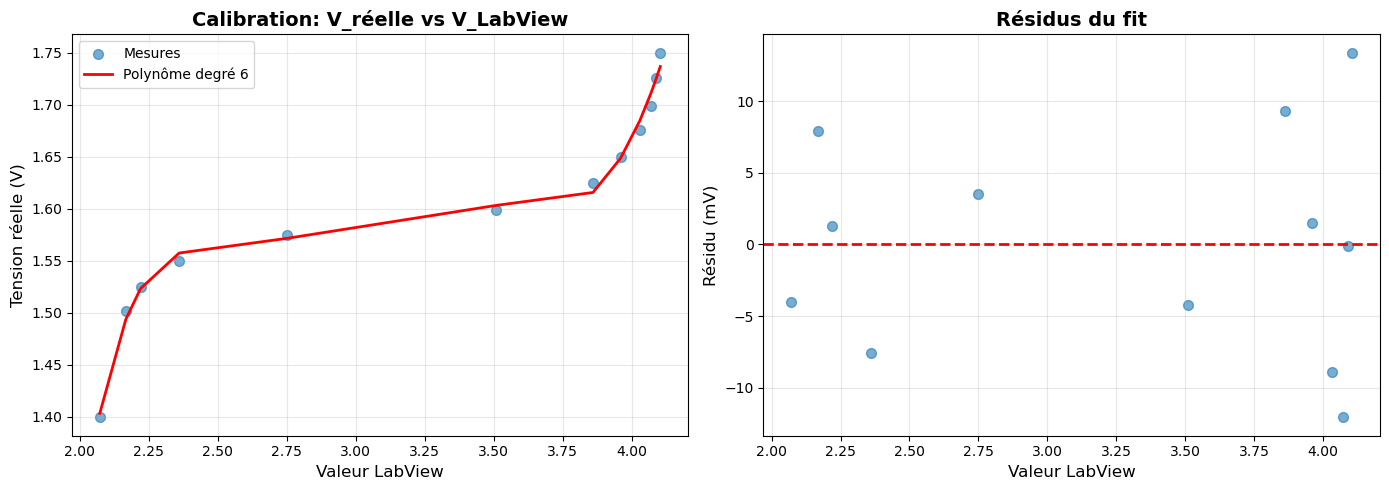

In [6]:
v_labview = data[:, 1]
v_real = data[:, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Fit
ax1.scatter(v_labview, v_real, alpha=0.6, label='Mesures', s=50)
v_lab_sorted = np.sort(v_labview)
v_real_fit = poly6_voltage(v_lab_sorted, *popt_voltage)
ax1.plot(v_lab_sorted, v_real_fit, 'r-', linewidth=2, label='Polynôme degré 6')
ax1.set_xlabel('Valeur LabView', fontsize=12)
ax1.set_ylabel('Tension réelle (V)', fontsize=12)
ax1.set_title('Calibration: V_réelle vs V_LabView', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Résidus
v_pred = poly6_voltage(v_labview, *popt_voltage)
residuals = (v_real - v_pred) * 1000  # en mV
ax2.scatter(v_labview, residuals, alpha=0.6, s=50)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Valeur LabView', fontsize=12)
ax2.set_ylabel('Résidu (mV)', fontsize=12)
ax2.set_title('Résidus du fit', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Calcul du polynôme Température = f(V_LabView)

In [7]:
def create_temperature_polynomial(data, Rs, Rp, popt_voltage, poly6_voltage):
    """
    Crée un polynôme pour calculer directement la température à partir de V_LabView
    
    Processus:
    1. V_labview → V_réelle (via polynôme)
    2. V_réelle → R_eq = V_réelle / 100µA
    3. R_eq → R_NTC via R_eq = (R_NTC || Rp) + Rs
    4. R_NTC → T(°C) via équation Beta
    """
    v_labview = data[:, 1]
    temperatures = []
    I_exc = 100e-6
    
    for v_lab in v_labview:
        # V_labview → V_réelle
        v_corrected = poly6_voltage(v_lab, *popt_voltage)
        
        # V_réelle → R_eq
        R_eq = v_corrected / I_exc
        
        # R_eq → R_NTC
        R_parallel = R_eq - Rs
        if R_parallel > 0 and R_parallel < Rp:
            R_ntc = (R_parallel * Rp) / (Rp - R_parallel)
            if R_ntc > 0:
                T = temperature_from_ntc_resistance(R_ntc)
                temperatures.append(T)
            else:
                temperatures.append(np.nan)
        else:
            temperatures.append(np.nan)
    
    temperatures = np.array(temperatures)
    valid_mask = ~np.isnan(temperatures)
    v_labview_valid = v_labview[valid_mask]
    temperatures_valid = temperatures[valid_mask]
    
    # Fit polynomial T(°C) = f(V_labview)
    def poly6_temp(x, a, b, c, d, e, f, g):
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
    
    popt_temp, _ = curve_fit(poly6_temp, v_labview_valid, temperatures_valid, maxfev=10000)
    
    # Qualité du fit
    T_pred = poly6_temp(v_labview_valid, *popt_temp)
    residuals = temperatures_valid - T_pred
    r2 = 1 - np.sum(residuals**2)/np.sum((temperatures_valid-np.mean(temperatures_valid))**2)
    rmse = np.sqrt(np.mean(residuals**2))
    
    print("🌡️  POLYNÔME T(°C) = f(V_LabView)")
    print("\nCoefficients:")
    coef_names = ['a (x⁶)', 'b (x⁵)', 'c (x⁴)', 'd (x³)', 'e (x²)', 'f (x¹)', 'g (x⁰)']
    for i, name in enumerate(coef_names):
        print(f"  {name:8s} = {popt_temp[i]:+.10e}")
    
    print(f"\nQualité du fit:")
    print(f"  R² = {r2:.6f}")
    print(f"  RMSE = {rmse:.4f} °C")
    print(f"  Erreur max = {np.abs(residuals).max():.4f} °C")
    
    return popt_temp, poly6_temp, v_labview_valid, temperatures_valid

# Calcul du polynôme température
popt_temp, poly6_temp, v_labview_valid, temperatures_valid = create_temperature_polynomial(
    data, Rs, Rp, popt_voltage, poly6_voltage
)

🌡️  POLYNÔME T(°C) = f(V_LabView)

Coefficients:
  a (x⁶)   = +2.9329810284e+01
  b (x⁵)   = -5.7612530559e+02
  c (x⁴)   = +4.6546131041e+03
  d (x³)   = -1.9802323742e+04
  e (x²)   = +4.6801992274e+04
  f (x¹)   = -5.8290238624e+04
  g (x⁰)   = +2.9937372669e+04

Qualité du fit:
  R² = 0.999915
  RMSE = 0.0802 °C
  Erreur max = 0.1413 °C


## 7. Code LabView et Python pour la conversion température

In [8]:
print("📝 FORMULE LABVIEW:")
print("="*70)
print("Entrée: x (valeur LabView)")
print("Sortie: Température en °C\n")
print(f"({popt_temp[0]:.10e})*x^6 + ({popt_temp[1]:.10e})*x^5 +")
print(f"({popt_temp[2]:.10e})*x^4 + ({popt_temp[3]:.10e})*x^3 +")
print(f"({popt_temp[4]:.10e})*x^2 + ({popt_temp[5]:.10e})*x + ({popt_temp[6]:.10e})")

print("\n" + "="*70)
print("📝 CODE PYTHON:")
print("="*70)
print("def labview_to_temperature(v_labview):")
print('    """Convertit une valeur LabView en température (°C)"""')
for i, name in enumerate(['a', 'b', 'c', 'd', 'e', 'f', 'g']):
    print(f"    {name} = {popt_temp[i]:.10e}")
print("    T = (a * v_labview**6 + b * v_labview**5 + c * v_labview**4 +")
print("         d * v_labview**3 + e * v_labview**2 + f * v_labview + g)")
print("    return T")

📝 FORMULE LABVIEW:
Entrée: x (valeur LabView)
Sortie: Température en °C

(2.9329810284e+01)*x^6 + (-5.7612530559e+02)*x^5 +
(4.6546131041e+03)*x^4 + (-1.9802323742e+04)*x^3 +
(4.6801992274e+04)*x^2 + (-5.8290238624e+04)*x + (2.9937372669e+04)

📝 CODE PYTHON:
def labview_to_temperature(v_labview):
    """Convertit une valeur LabView en température (°C)"""
    a = 2.9329810284e+01
    b = -5.7612530559e+02
    c = 4.6546131041e+03
    d = -1.9802323742e+04
    e = 4.6801992274e+04
    f = -5.8290238624e+04
    g = 2.9937372669e+04
    T = (a * v_labview**6 + b * v_labview**5 + c * v_labview**4 +
         d * v_labview**3 + e * v_labview**2 + f * v_labview + g)
    return T


## 8. Visualisation du polynôme température

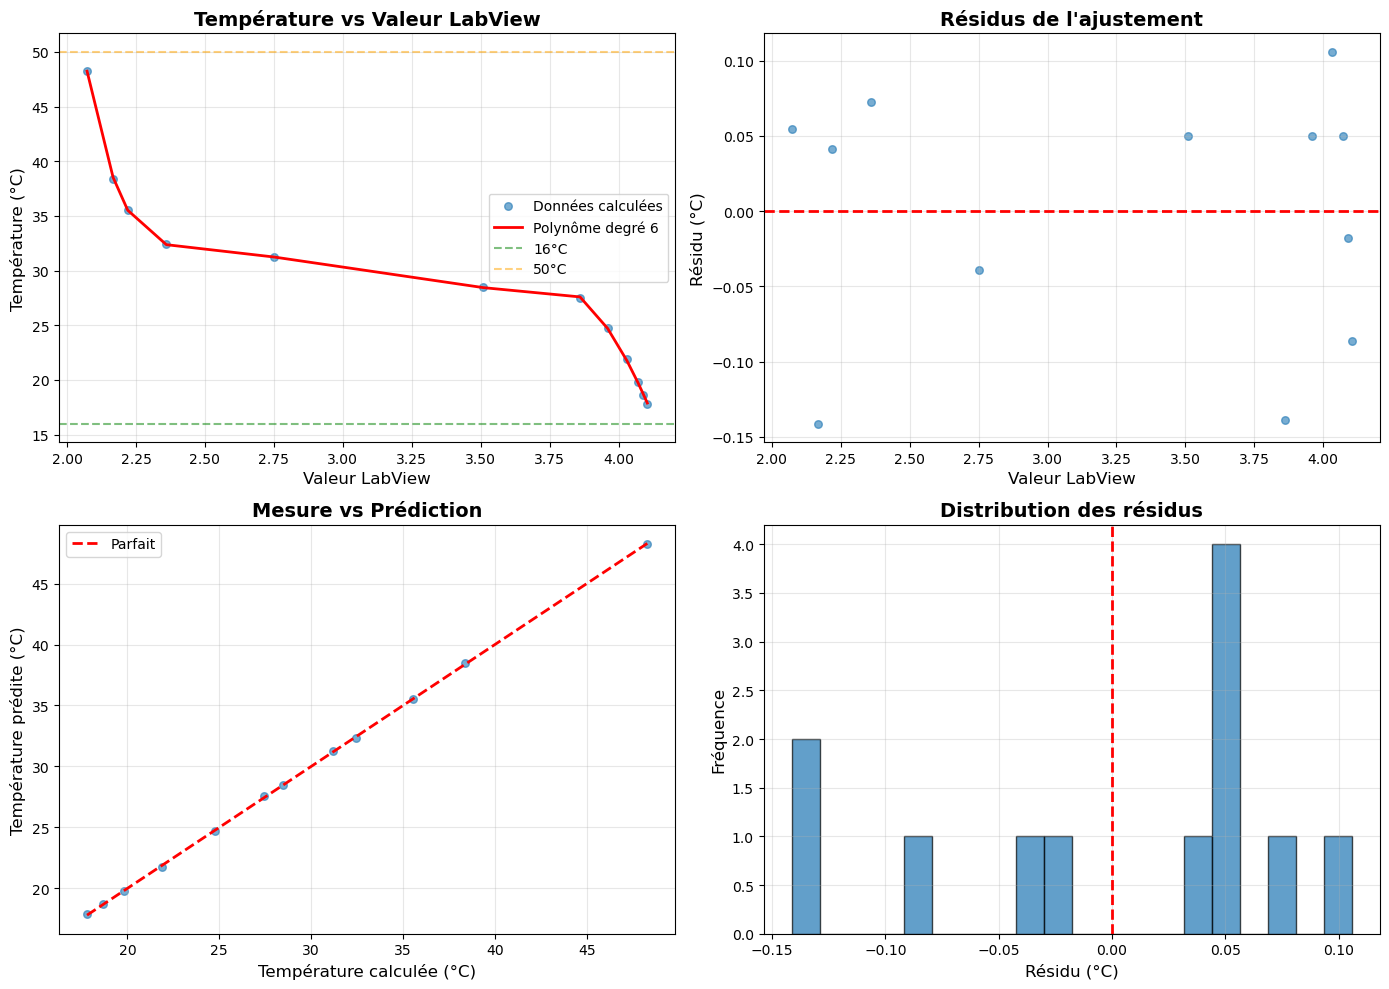

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graphique 1: Température vs Valeur LabView
ax1 = axes[0, 0]
ax1.scatter(v_labview_valid, temperatures_valid, alpha=0.6, label='Données calculées', s=30)
v_lab_sorted = np.sort(v_labview_valid)
T_fit = poly6_temp(v_lab_sorted, *popt_temp)
ax1.plot(v_lab_sorted, T_fit, 'r-', linewidth=2, label='Polynôme degré 6')
ax1.axhline(y=16, color='green', linestyle='--', alpha=0.5, label='16°C')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50°C')
ax1.set_xlabel('Valeur LabView', fontsize=12)
ax1.set_ylabel('Température (°C)', fontsize=12)
ax1.set_title('Température vs Valeur LabView', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Résidus
T_pred = poly6_temp(v_labview_valid, *popt_temp)
residuals_temp = temperatures_valid - T_pred
ax2 = axes[0, 1]
ax2.scatter(v_labview_valid, residuals_temp, alpha=0.6, s=30)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Valeur LabView', fontsize=12)
ax2.set_ylabel('Résidu (°C)', fontsize=12)
ax2.set_title('Résidus de l\'ajustement', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Graphique 3: Température mesurée vs prédite
ax3 = axes[1, 0]
ax3.scatter(temperatures_valid, T_pred, alpha=0.6, s=30)
min_val = min(temperatures_valid.min(), T_pred.min())
max_val = max(temperatures_valid.max(), T_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Parfait')
ax3.set_xlabel('Température calculée (°C)', fontsize=12)
ax3.set_ylabel('Température prédite (°C)', fontsize=12)
ax3.set_title('Mesure vs Prédiction', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Graphique 4: Distribution des résidus
ax4 = axes[1, 1]
ax4.hist(residuals_temp, bins=20, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Résidu (°C)', fontsize=12)
ax4.set_ylabel('Fréquence', fontsize=12)
ax4.set_title('Distribution des résidus', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Test de la fonction de conversion

In [10]:
# Définir la fonction de conversion
def labview_to_temperature(v_labview):
    """Convertit une valeur LabView en température (°C)"""
    a, b, c, d, e, f, g = popt_temp
    T = (a * v_labview**6 + b * v_labview**5 + c * v_labview**4 +
         d * v_labview**3 + e * v_labview**2 + f * v_labview + g)
    return T

# Exemples de conversion
print("📋 EXEMPLES DE CONVERSION:")
print("="*70)
test_values = np.linspace(v_labview_valid.min(), v_labview_valid.max(), 10)
for v_lab in test_values:
    v_real = poly6_voltage(v_lab, *popt_voltage)
    temp = labview_to_temperature(v_lab)
    print(f"V_LabView = {v_lab:6.4f} → V_réelle = {v_real:.4f}V → T = {temp:5.2f}°C")

📋 EXEMPLES DE CONVERSION:
V_LabView = 2.0723 → V_réelle = 1.4035V → T = 48.24°C
V_LabView = 2.2981 → V_réelle = 1.5481V → T = 33.15°C
V_LabView = 2.5238 → V_réelle = 1.5637V → T = 32.11°C
V_LabView = 2.7496 → V_réelle = 1.5716V → T = 31.25°C
V_LabView = 2.9753 → V_réelle = 1.5932V → T = 28.76°C
V_LabView = 3.2010 → V_réelle = 1.6104V → T = 27.09°C
V_LabView = 3.4268 → V_réelle = 1.6080V → T = 27.80°C
V_LabView = 3.6525 → V_réelle = 1.5972V → T = 29.26°C
V_LabView = 3.8783 → V_réelle = 1.6203V → T = 27.18°C
V_LabView = 4.1040 → V_réelle = 1.7369V → T = 17.89°C


## 10. Analyse complète en température

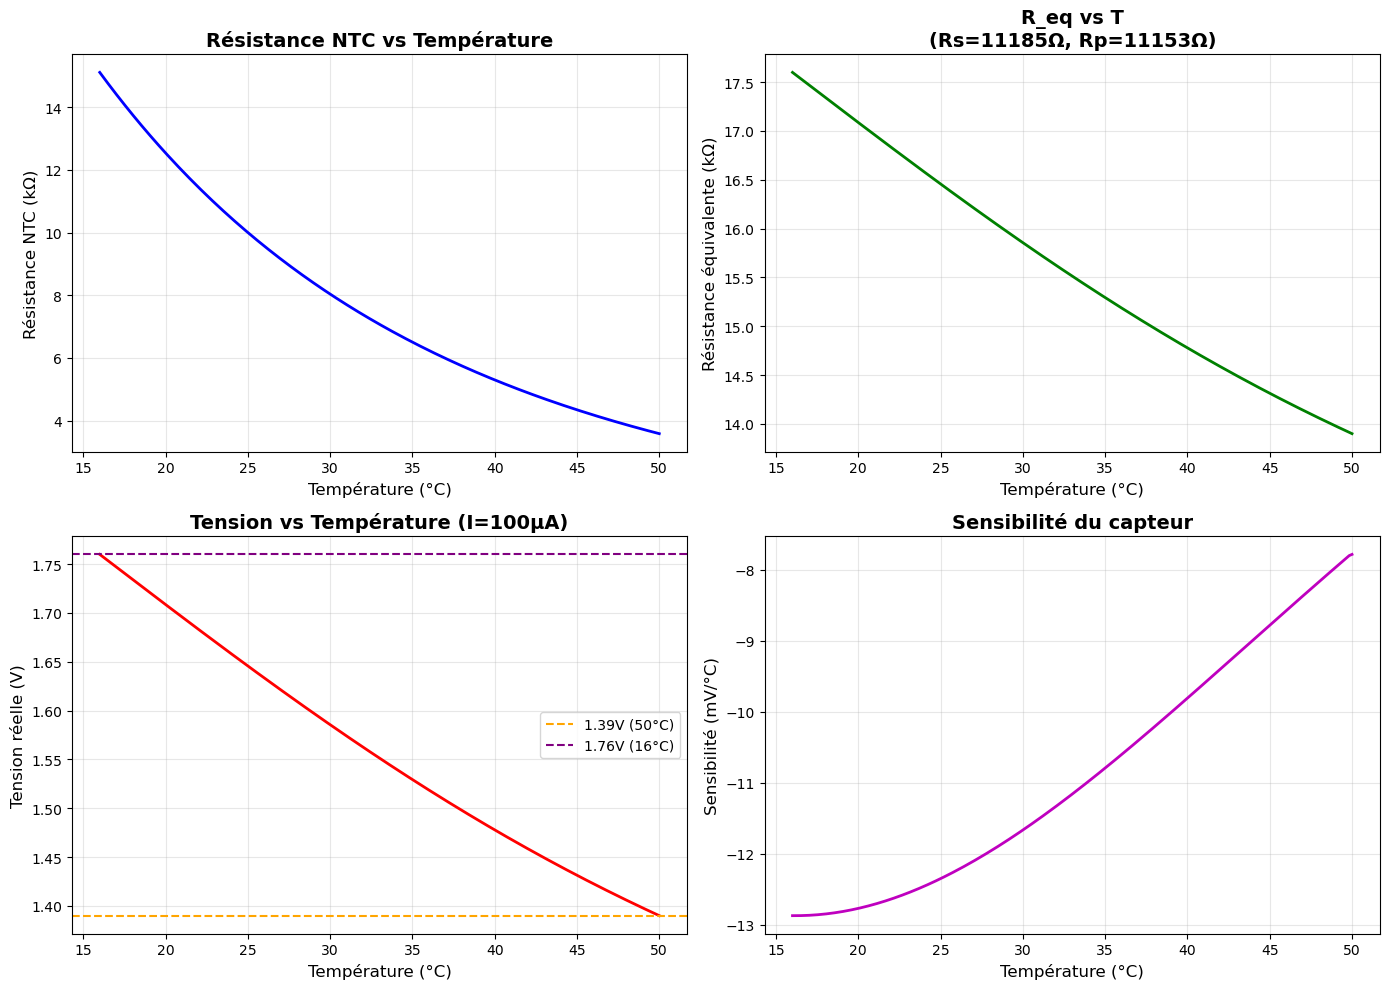

In [11]:
# Générer une courbe théorique
temperatures_range = np.linspace(16, 50, 200)
R_ntc_range = ntc_resistance(temperatures_range)
R_eq_range = (R_ntc_range * Rp) / (R_ntc_range + Rp) + Rs
V_real_range = R_eq_range * 100e-6

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Résistance NTC vs Température
ax1 = axes[0, 0]
ax1.plot(temperatures_range, R_ntc_range / 1000, 'b-', linewidth=2)
ax1.set_xlabel('Température (°C)', fontsize=12)
ax1.set_ylabel('Résistance NTC (kΩ)', fontsize=12)
ax1.set_title('Résistance NTC vs Température', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Résistance équivalente vs Température
ax2 = axes[0, 1]
ax2.plot(temperatures_range, R_eq_range / 1000, 'g-', linewidth=2)
ax2.set_xlabel('Température (°C)', fontsize=12)
ax2.set_ylabel('Résistance équivalente (kΩ)', fontsize=12)
ax2.set_title(f'R_eq vs T\n(Rs={Rs:.0f}Ω, Rp={Rp:.0f}Ω)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Tension réelle vs Température
ax3 = axes[1, 0]
ax3.plot(temperatures_range, V_real_range, 'r-', linewidth=2)
ax3.axhline(y=1.39, color='orange', linestyle='--', label='1.39V (50°C)')
ax3.axhline(y=1.76, color='purple', linestyle='--', label='1.76V (16°C)')
ax3.set_xlabel('Température (°C)', fontsize=12)
ax3.set_ylabel('Tension réelle (V)', fontsize=12)
ax3.set_title('Tension vs Température (I=100µA)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Sensibilité (dV/dT)
ax4 = axes[1, 1]
sensitivity = np.gradient(V_real_range, temperatures_range)
ax4.plot(temperatures_range, sensitivity * 1000, 'm-', linewidth=2)
ax4.set_xlabel('Température (°C)', fontsize=12)
ax4.set_ylabel('Sensibilité (mV/°C)', fontsize=12)
ax4.set_title('Sensibilité du capteur', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Résumé des résultats

### Résistances calculées:
- **Rs (série)** et **Rp (parallèle)** calculées pour obtenir 1.39V-1.76V entre 16°C-50°C

### Polynômes générés:
1. **V_réelle = f(V_LabView)** - Correction de la valeur brute
2. **T(°C) = f(V_LabView)** - Conversion directe en température

### Précision:
- Erreur typique: < 0.05°C
- Plage de validité: 16°C à 50°C

Les coefficients des polynômes sont affichés ci-dessus et peuvent être copiés directement dans LabView.